# Байесовская статистика
## Задание B.2


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---

**Баллы за задание:**

* Задача 1 — 20 баллов
* Задача 2 — 60 баллов
* Задача 3 — 40 баллов
* Задача 4 — 30 баллов
* Задача 5 — 40 баллов
* Задача 6 — 25 баллов
---

In [350]:
# Bot check

# HW_ID: ds_bayes2
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [351]:
import numpy as np

import scipy.stats as sps
import matplotlib.pyplot as plt
from tqdm import tqdm

---
### Задача 7

Предположим, что выборка из распределения $\mathcal{N}(\theta_1, \theta_2^{-1})$ приходит постепенно по 5 наблюдений за один раз. До получения первой партии из 5 наблюдений отсутствует какая-либо информация о значениях параметров $\theta = (\theta_1, \theta_2)$. После получения очередной партии наблюдений вычисляется апостериорное распределение параметров, используя в качестве априорного распределения предыдущее апостериорное распределение. Промоделируйте и визуализируйте такой эксперимент и опишите, как меняются знания о параметрах в процессе эксперимента.

In [352]:
def get_sample_norm(theta_1, theta_2, batch_size=5):
    """
    :returns: батч размера <batch_size> из распределения Bern(<theta>)
    """
    return np.random.normal(loc=theta_1, scale=1 / theta_2, size=batch_size)

In [353]:
def norm_posterior_params(batch, mu_prior, k_prior, a_prior, b_prior):
    """Обновление апостериорных параметров для нормального распределения"""
    n = len(batch)
    X_mean = np.mean(batch)
    S2 = np.var(batch, ddof=1)
    
    # Обновление параметров для μ
    k_poster = k_prior + n
    mu_poster = (k_prior * mu_prior + n * X_mean) / k_poster
    
    # Обновление параметров для τ (точности)
    a_poster = a_prior + n/2
    b_poster = b_prior + 0.5 * (n * S2 + k_prior * n * (X_mean - mu_prior)**2 / k_poster)
    
    return mu_poster, k_poster, a_poster, b_poster

In [354]:
def norm_posterior_params_batch(batch_count, mu_prior, k_prior, a_prior, b_prior, 
                              theta_1=0.5, theta_2=1, batch_size=5):
    """Последовательное обновление параметров после каждого батча"""
    posterior_params = [(mu_prior, k_prior, a_prior, b_prior)]

    for _ in range(batch_count):
        batch = get_sample_norm(theta_1, theta_2, batch_size)
        new_params = norm_posterior_params(batch, *posterior_params[-1])
        posterior_params.append(new_params)

    return np.array(posterior_params)

In [355]:
def draw_posteriori_norm(post_params, theta_1_true, theta_2_true, n_steps_to_show=5):
    """Рисует:
    1. Графики апостериорных распределений для μ и τ на ключевых шагах
    2. Траектории параметров с доверительными интервалами
    """
    plt.figure(figsize=(16, 10))
    
    # Выбираем равномерно распределенные шаги для отображения
    step_indices = np.linspace(0, len(post_params)-1, n_steps_to_show, dtype=int)
    
    # =============================================
    # 1. Графики апостериорных распределений
    # =============================================
    
    # Для μ (нормальное распределение)
    plt.subplot(2, 2, 1)
    x_mu = np.linspace(theta_1_true-3, theta_1_true+3, 500)
    for i in step_indices:
        mu, k, _, _ = post_params[i]
        y = sps.norm(loc=mu, scale=1/np.sqrt(k)).pdf(x_mu)
        plt.plot(x_mu, y, label=f'После {i} батчей', alpha=0.7)
    plt.axvline(theta_1_true, color='k', linestyle='--')
    plt.title('Апостериорные распределения для μ')
    plt.xlabel('μ')
    plt.ylabel('Плотность')
    plt.legend()
    
    # Для τ (гамма распределение)
    plt.subplot(2, 2, 2)
    x_tau = np.linspace(0, theta_2_true*3, 500)
    for i in step_indices:
        _, _, a, b = post_params[i]
        y = sps.gamma(a, scale=1/b).pdf(x_tau)
        plt.plot(x_tau, y, label=f'После {i} батчей', alpha=0.7)
    plt.axvline(theta_2_true, color='k', linestyle='--')
    plt.title('Апостериорные распределения для τ')
    plt.xlabel('τ')
    plt.ylabel('Плотность')
    plt.legend()
    
    # =============================================
    # 2. Траектории параметров (как в предыдущей версии)
    # =============================================
    
    # Для μ
    plt.subplot(2, 2, 3)
    mu_values = post_params[:, 0]
    k_values = post_params[:, 1]
    x = np.arange(len(mu_values))
    plt.plot(x, mu_values, 'b-')
    plt.fill_between(x, 
                    mu_values - 1/np.sqrt(k_values),
                    mu_values + 1/np.sqrt(k_values),
                    color='b', alpha=0.2)
    plt.axhline(theta_1_true, color='r', linestyle='--')
    plt.title('Эволюция оценки μ')
    plt.xlabel('Номер батча')
    plt.ylabel('μ')
    
    # Для τ
    plt.subplot(2, 2, 4)
    a_values = post_params[:, 2]
    b_values = post_params[:, 3]
    tau_est = a_values / b_values
    plt.plot(x, tau_est, 'g-')
    plt.fill_between(x, 
                    (a_values-1)/b_values,
                    (a_values+1)/b_values,
                    color='g', alpha=0.2)
    plt.axhline(theta_2_true, color='r', linestyle='--')
    plt.title('Эволюция оценки τ')
    plt.xlabel('Номер батча')
    plt.ylabel('τ')
    
    plt.tight_layout()
    plt.show()

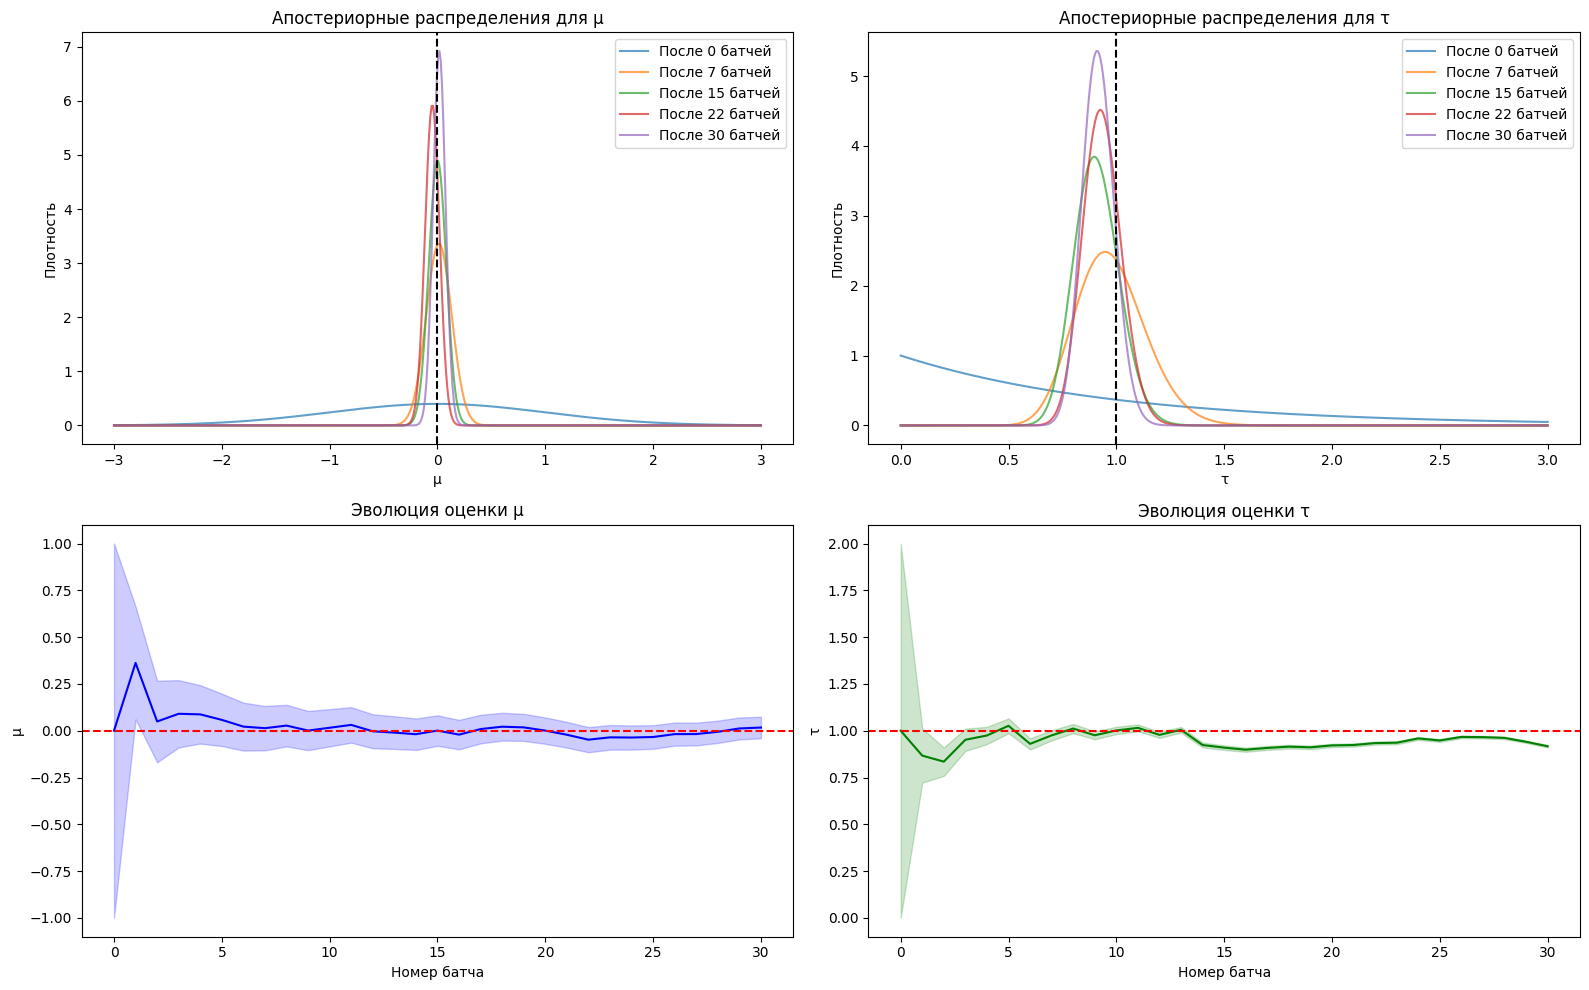

In [356]:
# Параметры
theta_1_true = 0  # Истинное среднее
theta_2_true = 1  # Истинная точность (τ = 1/σ²)
mu_prior = 0      # Априорное среднее
k_prior = 1       # Априорная точность для среднего
a_prior = 1       # Параметр формы для априорного гамма-распределения
b_prior = 1       # Параметр скорости для априорного гамма-распределения
batch_count = 30  # Количество батчей
batch_size = 10   # Размер батча

# Получаем апостериорные параметры
posterior_params = norm_posterior_params_batch(
    batch_count, mu_prior, k_prior, a_prior, b_prior,
    theta_1_true, theta_2_true, batch_size
)

# Рисуем графики
draw_posteriori_norm(posterior_params, theta_1_true, theta_2_true)

--- 

### Задача 1

Дана выборка из распределения $Bern(\theta)$:

In [357]:
sample = np.array([
    1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 
    0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0
])

В качестве априорного на $\theta$ рассматривается треугольное распределение:

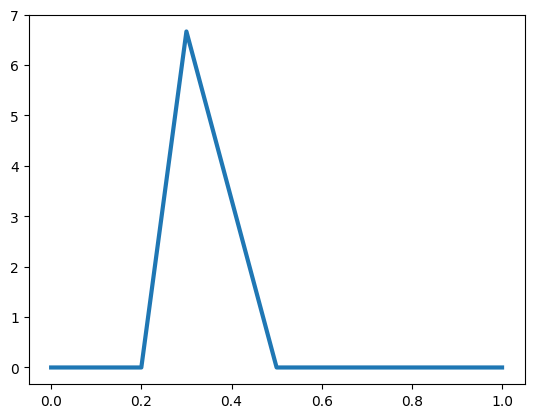

In [358]:
grid = np.linspace(0, 1, 1001)
dens = sps.triang(c=1/3, loc=0.2, scale=0.3).pdf(grid)

plt.plot(grid, dens, lw=3)
plt.show()

С помощью метода Монте-Карло постройте апостериорное распределение и найдите его математическое ожидание.

1) Апостериорное распределение.

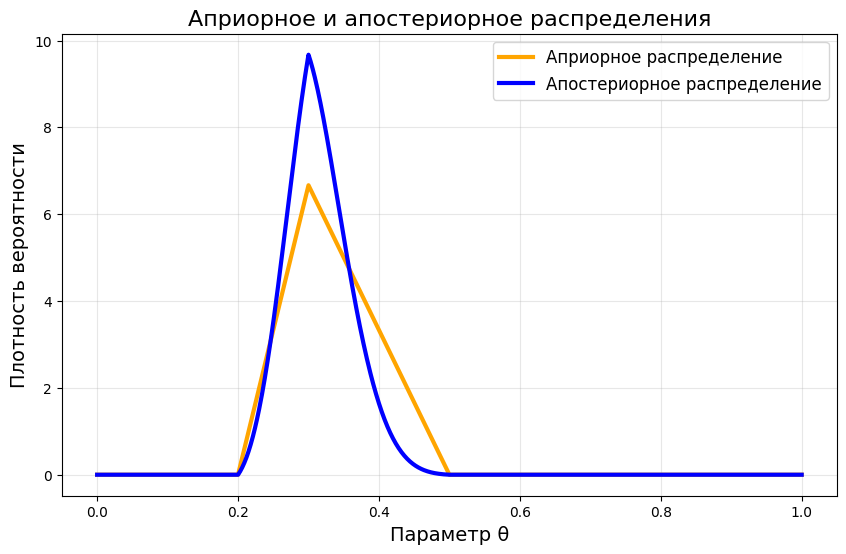

In [359]:
def q_post(aprior_distr, grid, x):
    return np.array(
        [aprior_distr.pdf(t) * np.prod(sps.bernoulli.pmf(x, t)) for t in grid]
    )


posterior = q_post(sps.triang(c=1 / 3, loc=0.2, scale=0.3), grid, sample)
posterior /= np.trapz(posterior, grid)

plt.figure(figsize=(10, 6))
plt.plot(grid, dens, lw=3, color='orange', label='Априорное распределение')
plt.plot(grid, posterior, lw=3, color='blue', label='Апостериорное распределение')
plt.xlabel("Параметр θ", fontsize=14)
plt.ylabel("Плотность вероятности", fontsize=14)
plt.title("Априорное и апостериорное распределения", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

2) Математическое ожидание.

In [360]:
expectation = np.mean(posterior * grid)
print(f"Математическое ожидание равно: {expectation:.2f}")

Математическое ожидание равно: 0.31


__________________
### Задача 2

В качестве байесовского доверительного интервала обычно рассматривают *область наибольшей плотности* (HDR, high density region) апостериорного распределения. 

Если $q(t)$ &mdash; плотность некоторого распределения, то множество $A$ называется $\alpha$-HDR, если 
* для некоторой $c > 0$ выполнено $\forall x \in A: q(t) \geqslant c$ и $\forall x \notin A: q(t) < c$, то есть внутри $A$ плотность выше, чем вне $A$;
* вероятность события $A$ не меньше $\alpha$
$$\int\limits_A q(t) dt \geqslant \alpha.$$

Как и для доверительных интервалов, при возможности стоит рассматривать такое множество, на котором достигается равенство в последнем неравенстве.

На схеме ниже приведена двумодальная плотность и визуализированы 0.75-HDR, состоящая из двух интервалов, а также доверительные интервалы, построенные с помощью среднего и дисперсии, а также квантилей.

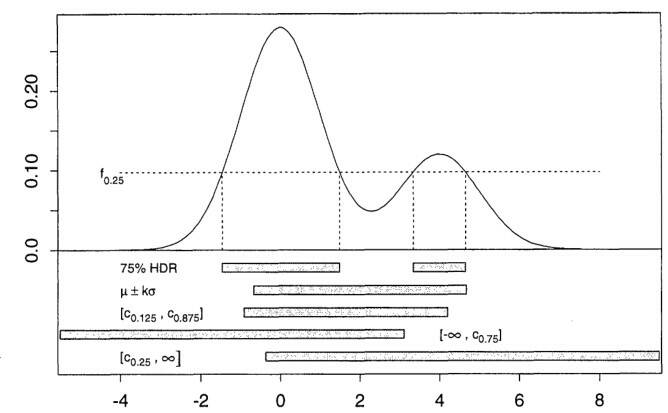


Напишите функцию, вычисляющую с некоторой точностью HDR для заданного распределения. Она должна уметь даже с распределениями, имеюшими странные или неограниченные носители, а также с такими расперделениями, про которые вообще мало что известно. Поэтому решение, где нужно заранее указывать область, на которой осуществляется поиск будет оценено в половину баллов. Можете считать, что у вас есть объект, у которого есть методы `pdf`, выдающий плотность в переданных точках и `rvs`, выдающий выборку заданного размера.

*Совет.* Для поиска $c$ используйте бинпоиск.

In [361]:
class Distribution:
    def __init__(self, distrs):
        self.distributions = distrs 

    def rvs(self, sample_size):
        indices = np.random.randint(0, len(self.distributions), size=sample_size)
        sample = np.array([self.distributions[i].rvs() for i in indices])
        return sample

    def pdf(self, grid):
        density_values = np.mean([distr.pdf(grid) for distr in self.distributions], axis=0)
        return density_values

In [362]:
def plot_distr(sample, A, threshold, boundries):
    plt.figure(figsize=(10, 6))
    plt.axhline(y=threshold, label=f"Значение c={threshold:.2f}", ls="--", c="red")
    for boundary in boundries:
        plt.plot([boundary[0], boundary[0]], [0, threshold], ls="--", c="red")
        plt.plot([boundary[1], boundary[1]], [0, threshold], ls="--", c="red")

    plt.hist(
        sample,
        bins=70,
        density=True,
        alpha=0.7,
        color="blue",
        label="Гистограмма выборки",
        edgecolor="black",
    )

    plt.plot(A, np.zeros_like(A), "ro", label="Множество A")

    plt.xlabel("Значения", fontsize=14)
    plt.ylabel("Частота", fontsize=14)
    plt.title("Гистограмма выборки", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

Threshold = 0.05
Integral value = 0.75


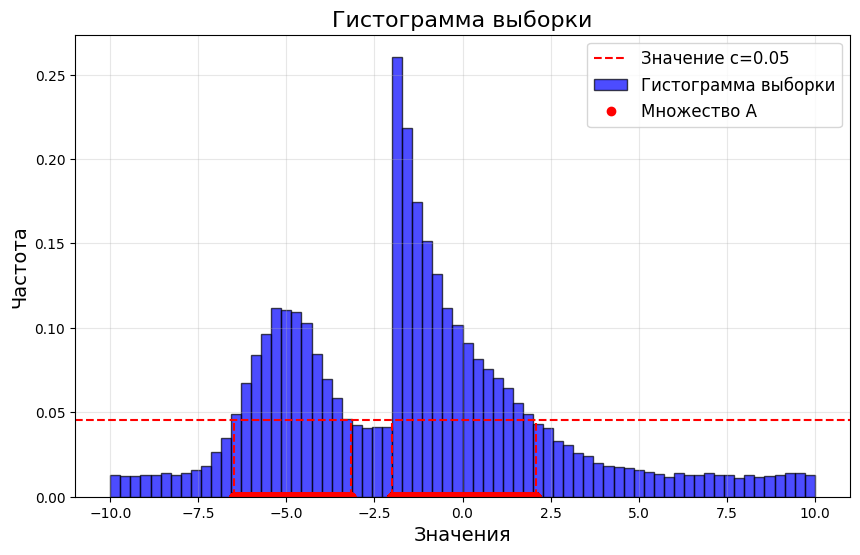

In [363]:
def calculate_integral(A, density_func, threshold=1e-2):
    if len(A) == 0:
        return 0, []

    sorted_A = np.sort(A)
    subarrays = []
    current_subarray = [sorted_A[0]]
    for i in range(1, len(sorted_A)):
        if sorted_A[i] - sorted_A[i - 1] > threshold:
            subarrays.append(np.array(current_subarray))
            current_subarray = [sorted_A[i]]
        else:
            current_subarray.append(sorted_A[i])
    subarrays.append(np.array(current_subarray))

    integral_value = 0
    boundries = []
    for subarray in subarrays:
        integral_value += np.trapz(density_func(subarray), subarray)
        boundries.append((subarray[0], subarray[-1]))

    return integral_value, boundries


def calculate_hdr(distribution, alpha, sample_size, show_fig=False):
    sample = distribution.rvs(sample_size)
    density_values = distribution.pdf(sample)

    c_low, c_high = np.min(density_values), np.max(density_values)
    c = np.mean([c_low, c_high])

    while True:
        A = sample[density_values >= c]
        integral_value, boundries = calculate_integral(A, distribution.pdf)

        if (np.abs(integral_value - alpha) < 0.001) and np.all(
            distribution.pdf(sample[density_values < c]) < c
        ):
            break

        if integral_value > alpha:
            c_low = c
        else:
            c_high = c

        old_c = c
        c = (c_low + c_high) / 2

        if np.abs(old_c - c) < 1e-6:
            raise ValueError(
                "Threshold convergence failed. The difference between old and new threshold is too small."
            )

    if show_fig:
        print(f"Threshold = {c:.2f}")
        print(f"Integral value = {integral_value:.2f}")
        plot_distr(sample, A, c, boundries)

    return A, c, boundries


distribution = Distribution(
    [
        sps.norm(loc=-5, scale=1),
        sps.norm(loc=0, scale=2),
        sps.uniform(loc=-10, scale=20),
        sps.expon(loc=-2, scale=1)
    ]
)
A, threshold, _ = calculate_hdr(distribution, 0.75, 100000, show_fig = True)
calculate_integral(A, distribution.pdf);

**Вывод**

Как видим, для подсчета HDR достаточно использовать только точки выборки, что логично, они уже содержат информацию о распределении, а значит и об мере A.

__________________
### Задача 3

Пусть $X_1, ..., X_n$ &mdash; выборка из распределения $Bern(\theta)$. В качестве априорного на $\theta$ рассматривается сопряжённое распределение. Исследуйте влияние параметров априорного распределения на скорость сходимости к истинному значению параметра.

Для экспериментов используйте истинное значение $\theta=0.15$. В качестве скорости сходимости рассматривайте минимальное количество элементов выборки, необходимое для выполнения двух условий:
* $\theta$ принадлежит 0.95-HDR,
* 0.95-HDR достаточно узкий &mdash; его ширина не превосходит 0.01.

Учтите, что эксперименты имеют стохастический характер.

*Как сделать вывод.*
* Рекомендации вида "брать такое априорное, которое ближе к истинному значению параметра" некорректны, поскольку само истинное значение параметра не известно. Какую-либо рекомендацию вообще дать невозможно.
* Заключения вида "если мы угадаем правильное априорное, то сойдемся быстро" также некорректны. Если мы как-то можем угадать "правильное" априорное распределение, то почему бы сразу не угадывать значение параметра?
* Априорное распределение &mdash; наши знания или представления о природе явления до начала эксперимента. Они могут примерно совпадать с реальностью или сильно отличаться от неё. В первом случае достаточно небольшого количества наблюдений для подтверждения наших знаний, во втором &mdash; потребуется достаточно большое количество наблюдений для переубеждения. Кроме того, на количество наблюдений влияет также то, насколько мы уверенны в наших априорных знаниях. Ваша задача &mdash; охарактеризовать подобным образом параметры сопряжённого семейства распределений к бернуллиевскому семейству.


Из предыдущего дз знаем, что сопряженным к бернуллевскому распределению является бета распределение.

In [364]:
theta_true = 0.15
alpha = 0.95
hdr_width = 0.01

a = np.random.uniform(0, 20)
b = 1 / np.random.uniform(0, 20)


In [365]:
def calculate_width(boundries):
    return sum(upper - lower for lower, upper in boundries)

def bern_posterior_params(sample, a, b):
    return a + np.sum(sample), b + len(sample) - np.sum(sample)

def check_theta_in_boundries(theta, boundries):
    for lower, upper in boundries:
        if (lower <= theta) and (theta <= upper):
            return True
    return False

В качестве параметра распределения будем брать оценку матожидания параметра.

In [366]:
def run_experiment(alpha, hdr_width, theta_true, a, b):
    sample_size_grid = np.arange(10000, 60000, 100)

    for sample_size in tqdm(sample_size_grid):
        sample = sps.bernoulli(p=theta_true).rvs(sample_size)
        a_posterior, b_posterior = bern_posterior_params(sample, a, b)
        distr = sps.beta(a_posterior, b_posterior)

        A, _, boundries = calculate_hdr(distr, alpha, sample_size)
        width = calculate_width(boundries)

        if width < hdr_width and check_theta_in_boundries(theta_true, boundries):
            print(f"Необходимый размер выборки: {sample_size}")
            break

Посмотрим на необходимые размеры выборок для разных неинформативных априоров

In [367]:
run_experiment(alpha, hdr_width, theta_true, a=0.5, b=0.5) # Джефферс

 19%|█▉        | 94/500 [00:09<00:41,  9.71it/s]

Необходимый размер выборки: 19400


In [368]:
run_experiment(alpha, hdr_width, theta_true, a=1, b=1) # Неинфорамативный

 19%|█▉        | 94/500 [00:10<00:43,  9.36it/s]

Необходимый размер выборки: 19400


In [369]:
a = np.random.uniform(0, 5)
b = np.random.uniform(0, 5)

run_experiment(alpha, hdr_width, theta_true, a=0, b=0) # Случайный априор

 19%|█▉        | 96/500 [00:09<00:41,  9.67it/s]

Необходимый размер выборки: 19600


**Выводы**

Как видим неинформативный априор требует чуть меньший размер выборки, возможно это связано тем, что он лучше подстраивается под распределение.

__________________
### Задача 4

Пусть $X = (X_1, ..., X_n)$ &mdash; выборка из экспоненциального распределения с параметрами сдвига $\theta_1$ и масштаба $\theta_2$. Плотность распределения имеет вид
    $$p_\theta(x) = \theta_2 e^{\theta_2 (\theta_1 - x)} I\{x \geqslant \theta_1\}.$$

Найдите апостериорное распределений (с учётом константы) если
* используется неинформативный априор(можете взять любой на ваш выбор);
* используется сопряжённое распределение в качестве априорного.

$\square$

СМ ПДФ

$\blacksquare$

----

### Задача 5

Вы пришли в казино и решили сыграть в слот-машину (их еще называют однорукими бандитами). Цель раунда &mdash; получить на барабане автомата выигрышную комбинацию и увеличить свою ставку. Предположим, что у каждой слот-машины существует некоторая фиксированная вероятность выигрыша. Причем разные автоматы могут иметь разные вероятности, которые не известны игроку, то есть вам. Изначально игрок ничего не знает про машины и они для него абсолютно одинаковы.

Можно интерпретировать эту задачу по-другому. Пусть у нас есть несколько дизайнов рекламы или формы регистрации. В каждом случае имеется своя вероятность совершить целевое действие, неизвестная для аналитика. Нашей задачей является максимизировать глобальное совершение целевого действия. То есть хотим понять, какой из дизайнов наиболее удачен, потеряв при этом минимальное число целевых действий из-за невыгодных показов.

Но вернемся в казино. Пусть есть 4 слот-машины. Ниже написаны их истинные вероятности выиграть, а так же функция, которая принимает на вход номер машины и возвращает исход раунда: победа ('W') или проигрыш ('L') 

In [479]:
thetas = [0, 0.10, 0.30, 0.40] # Не подглядывайте!

def play(j):
    """Имитирует слот-машину j
    
    :param j: индекс слот-машины
    
    :returns: 'W' или 'L'
    """
    
    return 'W' if sps.bernoulli(p=thetas[j]).rvs() == 1 else 'L'

В качестве распределения параметра $\theta_j$ будем использовать бета-распределение. Заполните массивы параметров $(\alpha_j, \beta_j)$ в соответствии с условием задачи (априорными знаниями):

Нам неизвестны начальные распределения, поэтому возьмем неинформативные априоры.

In [480]:
a  = [1 for _ in range(len(thetas))]
b  = [1 for _ in range(len(thetas))]

Ниже написана функция отрисовки распределения. Проверьте, что вы выбрали параметры правильно:

In [481]:
def plot_distr(alphas, betas):
    """Рисует 4 бета-распределения с заданными параметрами
    
    :param alphas, betas: параметры распределения, список длины 5
    """
    
    grid = np.arange(0, 1, 0.01)
    _, axes = plt.subplots(2, 2, figsize=(10, 5))
    plt.suptitle(r'Распределение вероятности выигрыша', fontsize=14)

    for j, (a, b, ax) in enumerate(zip(alphas, betas, axes.reshape(-1))):
        ax.set_title(f'Слот-машина {j+1}', fontsize=12)
        ax.plot(grid, sps.beta(a, b).pdf(grid), lw=2)
        ax.set_xlabel(r'$\theta$')

    plt.tight_layout()
    plt.show()

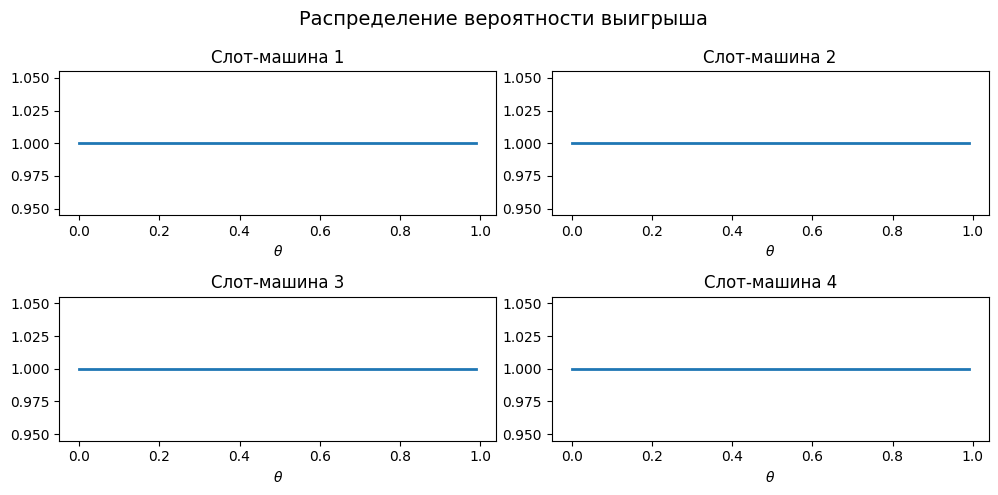

In [482]:
plot_distr(a, b)

Теперь допишите функцию, которая обновляет текущие параметра распределения машины на основе сыгранного раунда:

In [483]:
def update(alphas, betas, j, play):
    """Обновляет параметры распределений выбранной машины
    
    :param alphas, betas: параметры распределения, списки длины 5
    :param j: номер слот-машины
    :param play: исход раунда, 'W' или 'L' 
    """
    
    alphas[j] = alphas[j] + (play == "W")
    betas[j] = betas[j] + 1 - (play == "W")

По сути мы хотим неявно проверить множество гипотез $\mathsf{H}_j\colon$ машина $j$ оптимальна, где $j$ &mdash; номер автомата, при этом максимизируя суммарное количество побед.

Игрок хочет выиграть как можно больше и при этом готов сыграть не более 100 раз. Одной из стратегий в данном случае будет сыграть фиксированное и одинаковое число раз на всех автоматах, а затем выбрать тот, у которого наибольшая некоторая оценка вероятности выигрыша. Рассмотрим такой подход. Пусть мы сыграем сначала по 15 раз на каждом из автоматов, а затем оставшиеся 40 на том, который выберем. Посчитайте долю выигрышей в таком подходе:

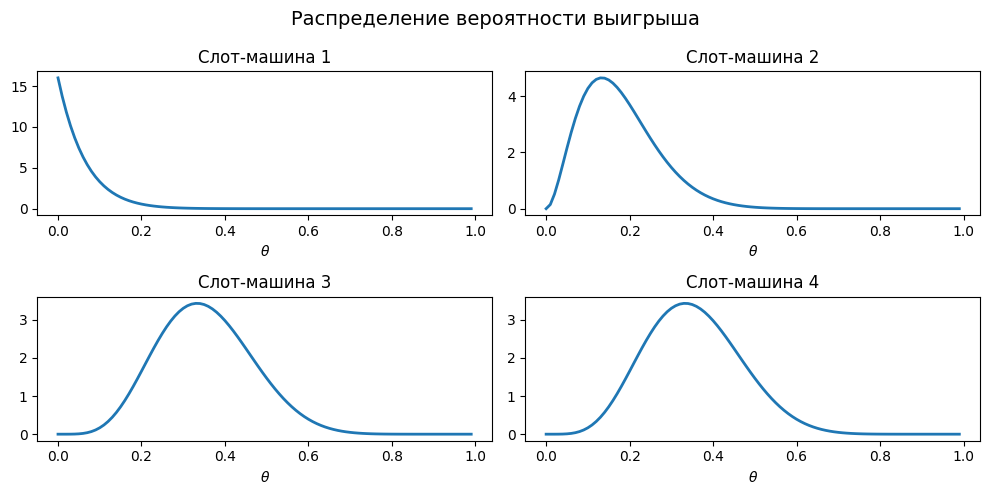

In [484]:
# кэш истории
history = []

for _ in range(15):
    for j in range(4):
        res = play(j)
        update(a, b, j, res)
        
        history.append([j, res == "W"])
        
history = np.array(history)
plot_distr(a, b)

Выберите наилучший автомат на основе, например, апостериорного матожидания и сыграйте оставшиеся 60 игр на нём:

In [485]:
best_machine = np.argmax([(a[j] / (a[j] + b[j])) for j in range(4)]) # история уже учтена при пересчете параметров

print(f"Лучший автомат: {best_machine}")

Лучший автомат: 2


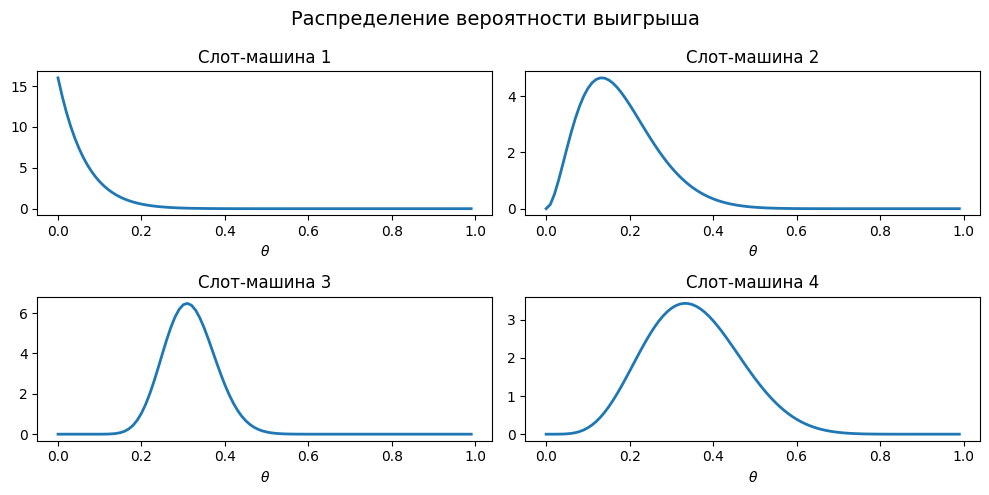

In [486]:
history = list(history)
for _ in range(40):
    res = play(best_machine)
    update(a, b, best_machine, res)
    history.append([best_machine, res == "W"])
history = np.array(history)
plot_distr(a, b)

Посчитайте долю побед в такой стратегии:

In [487]:
win_rate = np.mean(history[:, 1] == 1)
print(f"Win rate: {win_rate:.2%}")

Win rate: 24.00%


Заметим, что при такой стратегии много раундов уходит на то, чтоб получить оценку всех параметров. Более того, если оценки вышли неточные, то для дальнейшей игры мы можем выбрать не самый удачный автомат. Чтоб избавиться от этих проблем, рассмотрим другую стратегию. Пусть игрок считает автомат честным и продолжит в него играть, если вероятность выиграть в нем хотя бы $0.3$. Отсюда появляются гипотезы $\mathsf{H}_j^0\colon \theta \geq 0.3 \ \ vs.\ \ \mathsf{H}_j^1\colon \theta < 0.3$, где $j$ &mdash; номер автомата.

Сначала вернитесь к априорным параметрам:

In [488]:
a  = [1 for _ in range(len(thetas))]
b  = [1 for _ in range(len(thetas))]

Допишите функцию, вычисляющую байесовские факторы для гипотез выше:

In [489]:
def testing(alphas, betas):
    """ Вычисляет 4 баесовских фактора
    
    :params alphas, betas: параметры распределения, списки длины 4
    :returns: список длины 4
    """
    bayes_factors = []
    for a, b in zip(alphas, betas):
        p_1 = sps.beta(a, b).cdf(0.3)
        p_0 = 1 - p_1
        bayes_factors.append(p_0 / p_1)
    return bayes_factors

Дальше игрок выбирает автомат $j$ с наибольшим байесовским фактором в пользу  $\mathsf{H}_j^0$ и играет в него, продолжая пересчитывать параметры распределения. Если вдруг байесовский фактор $\beta_j$ стал меньше другого $\beta_k$, то игрок переходит к автомату $k$. Допишите функции, моделирующие поведение игрока:

In [490]:
def choose(factors):
    """ Выбирает автомат для следующего раунда
    :params factors: байесовские факторы автоматов
    
    :returns: номер автомата 
    """
    
    return np.argmax(factors)

In [491]:
def imitate_game(alphas, betas, rounds_count=100):
    """ Имитирует поведение игрока
    
    :params alphas, betas: параметры априорных распределений
    :params rounds_count: количество сыгранных раундов
    
    :returns: историю раундов ('W'/'L')
    """
    
    history = []
    
    for _ in tqdm(range(rounds_count)):
        factors = testing(alphas, betas)
        j = choose(factors)
        res = play(j)

        history.append([j, res == "W"])

        update(alphas, betas, j, res)
        
    return np.array(history)

Проведите 100 раундов игры по новой стратегии, визуализируйте полученные апостериорные распределения и посчитайте долю побед:

100%|██████████| 100/100 [00:00<00:00, 123.02it/s]


Win rate: 32.00%


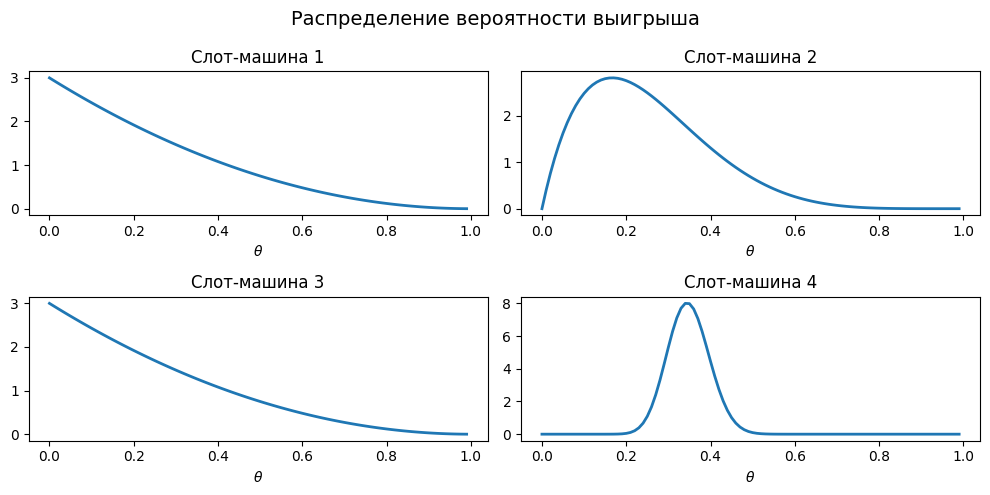

In [492]:
history = imitate_game(a, b, rounds_count=100)

win_rate = np.mean(history[:, 1] == 1)
print(f"Win rate: {win_rate:.2%}")

plot_distr(a, b)

Однако в данной стратегии все еще возможен выбор не самой удачной машины. Почему? Предложите и реализуйте третью стратегию, выбор в которой будет основан на байесовских факторах:

Может быть такое, что выборки которые нам приходят неудачны, и апостериорное распредление вместо того, чтобы стремится к истинному распределению напротив будет отклонятся от него.

Описание стратегии:

Будем выбирать автоматы не по одному байесовскому фактору, а по среднему среди них

In [493]:
def choose_robustly(factors):
    return np.argmax([np.sum(factor) if len(factor) > 0 else 0 for factor in factors])

Проведите 100 раундов игры по новой стратегии, визуализируйте полученные апостериорные распределения и посчитайте долю побед:

In [494]:
def imitate_game_robust(alphas, betas, rounds_count=100):
    """ Имитирует поведение игрока
    
    :params alphas, betas: параметры априорных распределений
    :params rounds_count: количество сыгранных раундов
    
    :returns: историю раундов ('W'/'L')
    """
    
    history = []
    factors = [[] * 4]
    
    for _ in tqdm(range(rounds_count)):
        tmp_factors = testing(alphas, betas)
        for factor, tmp_factors in zip(factors, tmp_factors):
            factor.append(tmp_factors)
        j = choose_robustly(factors)
        res = play(j)

        history.append([j, res == "W"])

        update(alphas, betas, j, res)
        
    return np.array(history)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 136.59it/s]


Win rate: 34.00%


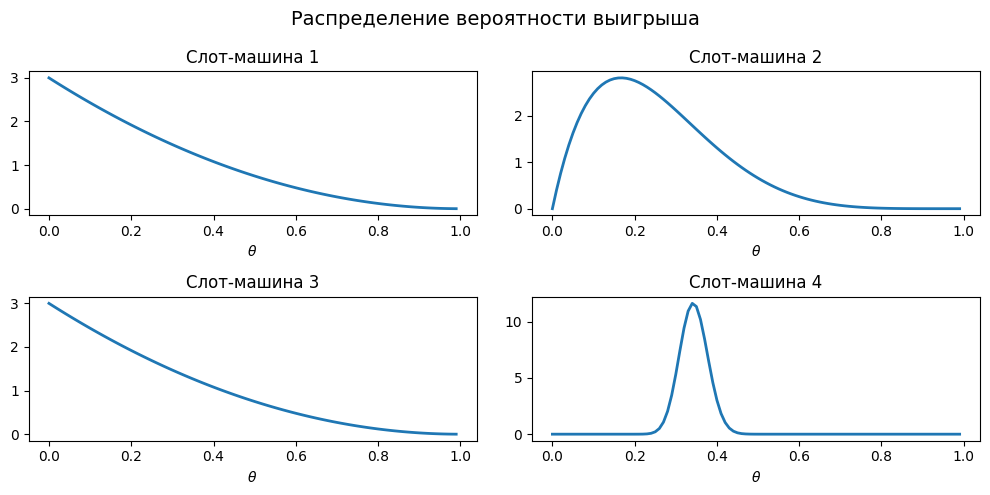

In [495]:
history = imitate_game(a, b, rounds_count=100)

win_rate = np.mean(history[:, 1] == 1)
print(f"Win rate: {win_rate:.2%}")

plot_distr(a, b)

---

### Задача 6

Рассмотрим выборку из экспоненциального распределения и гипотезы $\mathsf{H}_0\colon \theta < 0.5 \ vs\ \mathsf{H}_1\colon \theta \geq 0.5$

In [496]:
sample = [
    0.91931224, 2.16737761, 0.05347562, 1.09251725, 2.56295497,
    8.15872914, 0.33232659, 0.4751825 , 3.00461356, 0.87672092,
    0.03906482
]

In [497]:
def calculate_bf(alpha, beta, sample):
    pi_0 = sps.gamma(alpha, scale = 1 / beta).cdf(0.5)
    pi_1 = 1 - pi_0

    p_0 = sps.gamma(alpha + len(sample), scale = 1 / (beta + np.sum(sample))).cdf(0.5)
    p_1 = 1 - p_0

    bf = p_0 / p_1 * pi_1 /pi_0

    return bf, pi_0, pi_1, p_0, p_1

Подберите сопряжённое априорное так, чтоб априорные вероятности гипотез были примерно равны:

In [498]:
alpha = 1
beta = 1.39

np.round(calculate_bf(alpha, beta, sample)[1:3], 3)

array([0.501, 0.499])

Расчитайте байесовский фактор в пользу $\mathsf{H}_0$:

In [499]:
print(f"Байесовский фактор равен {calculate_bf(alpha, beta, sample)[0]:.2f}")

Байесовский фактор равен 0.57


Что можно сказать про гипотезы?

**Ответ:** Байесовский фактор получился меньше 1, поэтому скорее не верим в $H_0$. 

Теперь рассмотрим априорное распределение, в котором $\mathsf{H}_0$ более вероятно, чем $\mathsf{H}_1$ примерно в 2 раза:

In [500]:
a_prior = 1
b_prior = 0.5

Проведите проверку гипотез:

In [501]:
print(f"Байесовский фактор равен {calculate_bf(a_prior, b_prior, sample)[0]:.2f}")

Байесовский фактор равен 1.61


Сравните полученные байесовские факторы при различных априорных распределениях. Почему возникает такой эффект?

In [502]:
for a, b in zip([0.5, 1, 2, 3], [0.5, 1, 2, 3]):
    print(f"alpha = {a}, beta = {b}")
    print(f"Байесовский фактор равен {calculate_bf(a, b, sample)[0]:.2f}\n")


alpha = 0.5, beta = 0.5
Байесовский фактор равен 0.54

alpha = 1, beta = 1
Байесовский фактор равен 0.80

alpha = 2, beta = 2
Байесовский фактор равен 1.16

alpha = 3, beta = 3
Байесовский фактор равен 1.42



Потому что подобранные априорные значения лучше отражают истинное распределение параметра.

**Ответ:** Байсовский фактор в полтора раза больще единицы, поэтому мы скорее верим в верность гипотезы $H_0$

Попробуем поменять априорные вероятности. Теперь $\mathsf{H}_0$ менее вероятно примерно в два раза:

In [503]:
a_prior = 4
b_prior = 3

Проведите проверку гипотез:

In [504]:
print(f"Байесовский фактор равен {calculate_bf(a_prior, b_prior, sample)[0]:.2f}")

Байесовский фактор равен 2.95


Значит гипотеза скорее верна.

Что в итоге можно сказать про гипотезы?

**Вывод:** 

Мы видим, что значение байсовского фактора в значительной мере зависит от априорных значений.

Но в силу того, что гипотеза скорее верна в прямо противополжных предположениях, можно сделать вывод, что гипотеза в целом скорее верна.